In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [127]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [128]:
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words[:]:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words)) 
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [12]:
#embedding matrix C
C = torch.randn((27,2))
print(C.dtype)
C[5]

torch.float32


tensor([ 0.3526, -0.9198])

In [20]:
#get 2d embedding for each of 32 by 3 inputs 
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [18]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W1.shape 

torch.Size([6, 100])

In [38]:
h = torch.tanh(emb.view(-1,6)@W1 + b1)

In [39]:
h.shape

torch.Size([32, 100])

In [40]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [41]:
logits = h@W2 +b2

In [42]:
logits.shape

torch.Size([32, 27])

In [46]:
counts = logits.exp()

In [53]:
prob = counts/counts.sum(1, keepdim=True)
prob[0].sum()

tensor(1.)

In [56]:
Y.shape
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [57]:
loss = -prob[torch.arange(32),Y].log().mean()

In [58]:
loss

tensor(17.3110)

In [176]:
#neatly written up
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30 ,200), generator=g)
b1 = torch.randn((200), generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C,W1,b1,W2,b2]


In [177]:
sum(p.nelement() for p in parameters)

11897

In [178]:
for p in parameters:
    p.requires_grad = True

In [129]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [179]:
lri = []
stepi = []
lossi = []

In [188]:
for i in range(50000):
    # construct a mini batch
    ix = torch.randint(0, Xtr.shape[0],(32,))
    #forward pass
    emb = C[Xtr[ix]] #(32,3,2)
    h = torch.tanh(emb.view(-1,30)@W1 +b1)
    logits = h@W2 +b2
    loss = F.cross_entropy(logits,Ytr[ix])
    # print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = 0.01
    for p in parameters:
        p.data += -lr*p.grad
    #track stats
    # lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item()) 


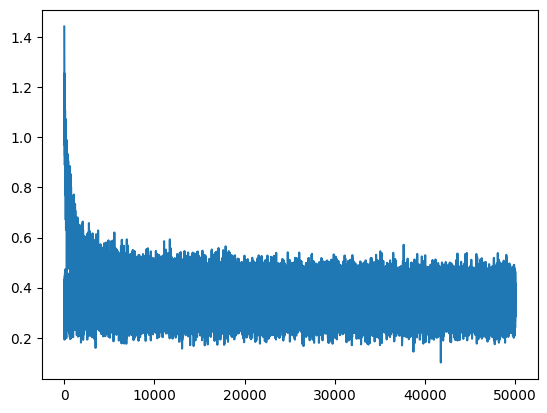

In [189]:
plt.plot(stepi,lossi)

In [190]:
emb = C[Xtr] #(32,3,2)
h = torch.tanh(emb.view(-1,30)@W1 +b1)
logits = h@W2 +b2
loss = F.cross_entropy(logits,Ytr)
loss.item()

2.1760125160217285

In [191]:
emb = C[Xdev] #(32,3,2)
h = torch.tanh(emb.view(-1,30)@W1 +b1)
logits = h@W2 +b2
loss = F.cross_entropy(logits,Ydev)
loss.item()

2.197052001953125

In [ ]:
#training, dev/validation, test
# 80% , 10%, 10%

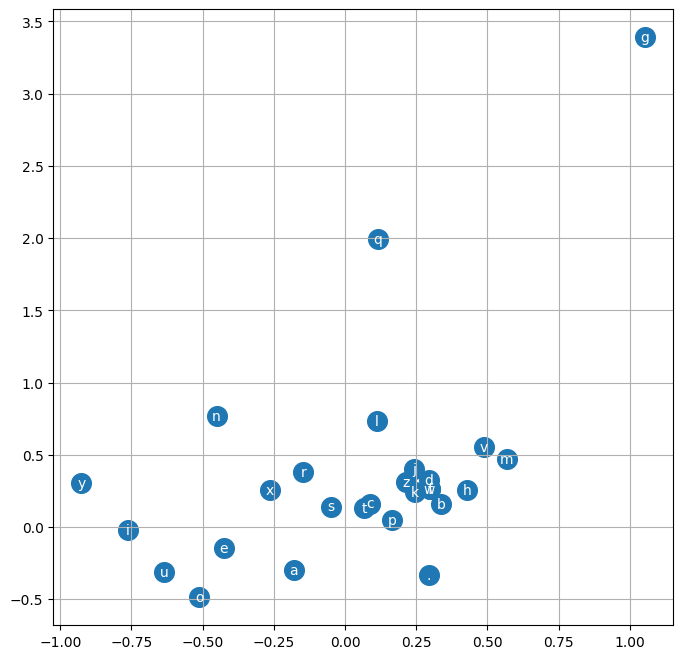

In [175]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),itos[i], ha = 'center', va = 'center', color = 'white')
plt.grid('minor')

In [230]:
#inference:
for i in range(20):
    out = []
    context = [0]*block_size #ie ...
    while True:
        #get embeddings 
        emb = C[torch.tensor([context])] #shape is (1,block_size,d) where d is embedding size
        h = torch.tanh(emb.view(1,-1)@W1 +b1)
        logits = h@W2 +b2
        prob = logits.softmax(dim=1)
        ix = torch.multinomial(prob,num_samples=1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    name = ''.join(itos[i] for i in out)
    print(name)


deo.
eelabygana.
cally.
chaiin.
kressyn.
daes.
shianna.
maradaleeklioverai.
eever.
ken.
arielly.
trick.
ami.
dowel.
jraloniyah.
salani.
chaiiia.
bly.
blicasley.
tayah.


In [227]:
logits.shape


torch.Size([1, 27])